In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# opensoundscape transfer learning tools
# from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings

## Load Data

In [ ]:
df_wmm = pd.read_csv('../../Dataset/CSVs/Datasets/WatkinsMarineMammalsSegmented.csv')
df_neus_mm = pd.read_csv('../../Dataset/CSVs/Datasets/NeusMarineMammalsSegmented.csv')
df_sam_background = pd.read_csv('../../Dataset/CSVs/Datasets/SEANIMALMOVEBackgroundSegmented.csv')
df_neus_bg = pd.read_csv('../../Dataset/CSVs/Datasets/NeusBackgroundFastFerries.csv')
df_circe_mm = pd.read_csv("../../Dataset/CSVs/Datasets/CIRCEMarineMammalsSegmented.csv")

In [ ]:
df_wmm = df_wmm[df_wmm['Class'].isin(['BottlenoseDolphin', 'CommonDolphin', "Grampus_Risso'sDolphin", 'HarborPorpoise', 'KillerWhale', 'Long_FinnedPilotWhale', 'StripedDolphin'])]
df_wmm = df_wmm.reset_index(drop=True)

# Take maximum 1000 random samples per class in Train Subset and 150 random samples per Val and test subset
df_train_wmm = df_wmm[df_wmm['Subset'] == 'train']
df_val_wmm = df_wmm[df_wmm['Subset'] == 'val']
df_test_wmm = df_wmm[df_wmm['Subset'] == 'test']

df_train_wmm = df_train_wmm.groupby('Class').apply(lambda x: x.sample(min(len(x), 700), random_state=42)).reset_index(drop=True)
df_val_wmm = df_val_wmm.groupby('Class').apply(lambda x: x.sample(min(len(x), 150), random_state=42)).reset_index(drop=True)
df_test_wmm = df_test_wmm.groupby('Class').apply(lambda x: x.sample(min(len(x), 1000), random_state=42)).reset_index(drop=True)

df_wmm = pd.concat([df_train_wmm, df_val_wmm, df_test_wmm])

/tmp/ipykernel_83894/3632992436.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_wmm = df_train_wmm.groupby('Class').apply(lambda x: x.sample(min(len(x), 700), random_state=42)).reset_index(drop=True)
/tmp/ipykernel_83894/3632992436.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_val_wmm = df_val_wmm.groupby('Class').apply(lambda x: x.sample(min(len(x), 150), random_state=42)).reset_inde

In [ ]:
df = pd.concat([df_wmm, df_neus_mm, df_sam_background, df_neus_bg, df_circe_mm])
df.head()

,FilePath,SegmentPath,Class,Duration,Origin,Subset
0,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,BottlenoseDolphin,3.0,Watkins Marine Mammals,train
1,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,BottlenoseDolphin,3.0,Watkins Marine Mammals,train
2,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,BottlenoseDolphin,3.0,Watkins Marine Mammals,train
3,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,BottlenoseDolphin,3.0,Watkins Marine Mammals,train
4,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,BottlenoseDolphin,3.0,Watkins Marine Mammals,train


## Data preprocessing

Class: CommonDolphin


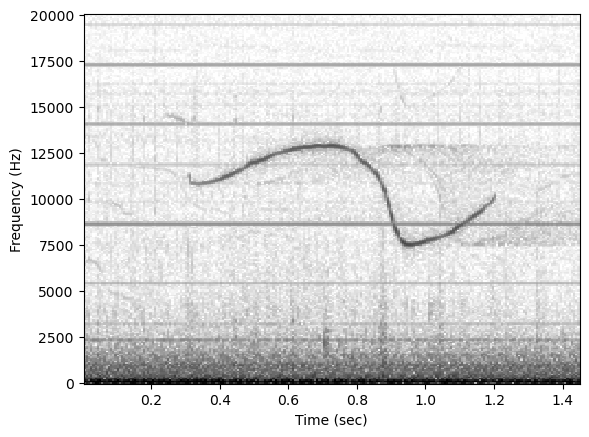

In [ ]:
# Function to process audio files
def process_audio_to_spectrogram(audio_path):
    try:
        audio = Audio.from_file(audio_path)  # Load audio
        spec = Spectrogram.from_audio(audio)  # Convert to spectrogram
        return spec
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Example: Convert first audio file
sample_audio = df["SegmentPath"].iloc[751]  # Use segment path for consistency
sample_label = df["Class"].iloc[751]  # Get the class label
sample_spectrogram = process_audio_to_spectrogram(sample_audio)

# Display the spectrogram
if sample_spectrogram:
    print(f"Class: {sample_label}")
    sample_spectrogram.plot()

## Splitting the data

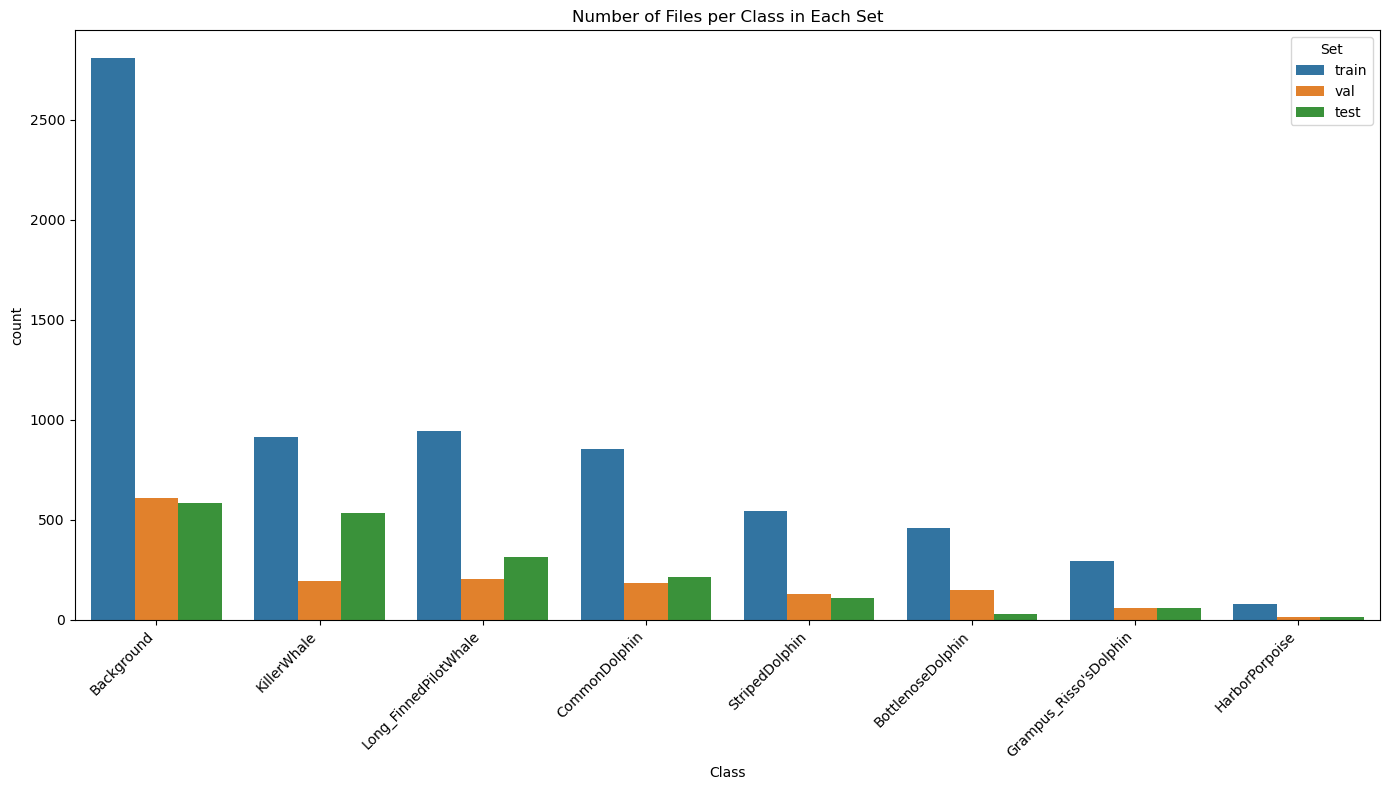

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create train-test split (80-20)
train_df = df[df["Subset"] == "train"]
val_df = df[df["Subset"] == "val"]
test_df = df[df["Subset"] == "test"]

# Plot count per class, each subset is a bar for each class (train, val and test)
class_counts = df['Class'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='Class', hue='Subset', order=class_counts.index)
plt.title('Number of Files per Class in Each Set')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust fontsize and alignment
plt.legend(title='Set')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

## OpenSoundScape Dataset

In [ ]:
def load_labels_from_df(df):
    # Listar las clases únicas
    class_labels = sorted(df['Class'].unique())

    # Crear una nueva lista para los resultados
    data = []

    # Iterar sobre las filas del dataframe original
    for _, row in df.iterrows():
        # Extraer la ruta de archivo y la duración
        file_path = row['SegmentPath']
        duration = round(row['Duration'], 2) - 0.03
        start_time = 0
        end_time = start_time + duration
        
        # Crear una fila con la información de tiempo y clases
        row_data = {
            'file': file_path,
            'start_time': start_time,
            'end_time': end_time
        }
        
        # Marcar las clases correspondientes en cada intervalo
        for label in class_labels:
            # Si el intervalo pertenece a esta clase, marcamos True, sino False
            if row['Class'] == label:
                row_data[label] = True
            else:
                row_data[label] = False
        
        # Agregar la fila generada al conjunto de datos
        data.append(row_data)

    # Convertir la lista de filas a un DataFrame
    df_labels = pd.DataFrame(data)

    # Reorganizar las columnas para tener file, start_time, end_time seguidos de las clases
    df_labels = df_labels[['file', 'start_time', 'end_time'] + list(class_labels)]

    # Establecer el índice como 'file', 'start_time', y 'end_time'
    df_labels.set_index(['file', 'start_time', 'end_time'], inplace=True)

    return df_labels

train_labels = load_labels_from_df(train_df)
val_labels = load_labels_from_df(val_df)
test_labels = load_labels_from_df(test_df)

In [ ]:
train_labels

,,,Background,BottlenoseDolphin,CommonDolphin,Grampus_Risso'sDolphin,HarborPorpoise,KillerWhale,Long_FinnedPilotWhale,StripedDolphin
file,start_time,end_time,,,,,,,,
../../Dataset/Audios/Watkins Marine Mammals/Segmented/BottlenoseDolphin/90033004_180.0_183.0.wav,0,2.97,False,True,False,False,False,False,False,False
../../Dataset/Audios/Watkins Marine Mammals/Segmented/BottlenoseDolphin/90033005_66.0_69.0.wav,0,2.97,False,True,False,False,False,False,False,False
../../Dataset/Audios/Watkins Marine Mammals/Segmented/BottlenoseDolphin/90033004_207.0_210.0.wav,0,2.97,False,True,False,False,False,False,False,False
../../Dataset/Audios/Watkins Marine Mammals/Segmented/BottlenoseDolphin/90033004_198.0_201.0.wav,0,2.97,False,True,False,False,False,False,False,False
../../Dataset/Audios/Watkins Marine Mammals/Segmented/BottlenoseDolphin/90033003_21.0_24.0.wav,0,2.97,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
../../Dataset/Audios/CIRCE/Long_FinnedPilotWhale/GM_00105.wav,0,1.17,False,False,False,False,False,False,True,False
../../Dataset/Audios/CIRCE/Long_FinnedPilotWhale/GM_00053.wav,0,0.63,False,False,False,False,False,False,True,False
../../Dataset/Audios/CIRCE/Long_FinnedPilotWhale/GM_00143.wav,0,0.95,False,False,False,False,False,False,True,False


## Train Model

In [ ]:
bmz.list_models()

Using cache found in /home/gruncrow/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_0.11.0.dev1
2025-02-19 09:13:59.169085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739952839.233310   83894 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739952839.253674   83894 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 09:13:59.416179: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


['BirdNET',
 'HawkEars',
 'MissingHawkearsDependency',
 'MissingTFDependency',
 'Perch',
 'SeparationModel',
 'YAMNet',
 'rana_sierrae_cnn']

In [ ]:

# Load a pretrained model
birdnet = bmz.load('BirdNET')  # or bmz.load('Perch')

ModuleNotFoundError: No module named 'torch'

In [23]:
# Embed the training labels
emb_train = birdnet.embed(train_labels, return_dfs=False, batch_size=16, num_workers=0)

  0%|          | 0/431 [00:00<?, ?it/s]

ValueError: Cannot set tensor: Dimension mismatch. Got 16 but expected 1 for dimension 0 of input 0.

In [54]:
emb_val = perch.embed(val_labels, return_dfs=False, batch_size=16, num_workers=0)

  0%|          | 0/97 [00:00<?, ?it/s]

/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 0.70996875 sec instead of 0.71 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 0.68996875 sec instead of 0.69 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.38996875 sec instead of 1.39 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 0.56996875 sec instead of 0.57 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape

In [55]:
perch.change_classes(sorted(df['Class'].unique()))

In [56]:
quick_fit(perch.network, emb_train, train_labels.values, emb_val, val_labels.values,steps=1000)

Epoch 100/1000, Loss: 0.23077647387981415, Val Loss: 0.2378878891468048
val AU ROC: 0.517
val MAP: 0.517
Epoch 200/1000, Loss: 0.18525287508964539, Val Loss: 0.19134263694286346
val AU ROC: 0.593
val MAP: 0.593
Epoch 300/1000, Loss: 0.16062499582767487, Val Loss: 0.16700150072574615
val AU ROC: 0.654
val MAP: 0.654
Epoch 400/1000, Loss: 0.1440683901309967, Val Loss: 0.15125486254692078
val AU ROC: 0.687
val MAP: 0.687
Epoch 500/1000, Loss: 0.1317618191242218, Val Loss: 0.13989396393299103
val AU ROC: 0.711
val MAP: 0.711
Epoch 600/1000, Loss: 0.12207234650850296, Val Loss: 0.13117675483226776
val AU ROC: 0.729
val MAP: 0.729
Epoch 700/1000, Loss: 0.11414116621017456, Val Loss: 0.12421268969774246
val AU ROC: 0.745
val MAP: 0.745
Epoch 800/1000, Loss: 0.10746530443429947, Val Loss: 0.11848621070384979
val AU ROC: 0.757
val MAP: 0.757
Epoch 900/1000, Loss: 0.10172855854034424, Val Loss: 0.11367401480674744
val AU ROC: 0.770
val MAP: 0.770
Epoch 1000/1000, Loss: 0.09672015905380249, Val L

In [57]:
# calculate test embeddings
emb_test = perch.embed(test_labels, return_dfs=False, batch_size=16, num_workers=0)

  0%|          | 0/116 [00:00<?, ?it/s]

/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 2.3699375 sec instead of 2.37 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.25996875 sec instead of 1.26 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 2.9699375 sec instead of 2.97 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.43996875 sec instead of 1.44 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/a

In [58]:
# make predictions by passing the embeddings through the classifier
preds = perch.network(torch.tensor(emb_test).float()).detach().numpy()
# take a different classifier
clf = MLPClassifier(input_size=emb_train.shape[1], hidden_size=256, num_classes=len(perch.classes))ç
# fit the classifier on the embeddings
clf = fit_classifier_on_embeddings(clf, emb_train, train_labels.values, emb_val, val_labels.values, steps=1000)

array([0.99981663, 0.93322368, 0.97664491, 0.95586213, 0.92752329,
       0.96458288, 0.96378122, 0.94960384])

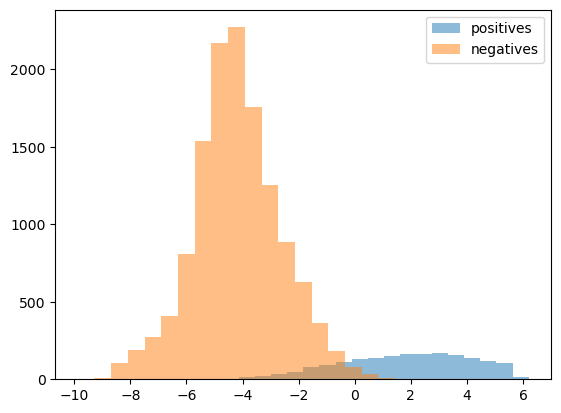

In [59]:
from sklearn.metrics import roc_auc_score

# plot histogram of scores for positive and negative clips
plt.hist(preds[test_labels==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[test_labels==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score(test_labels.values,preds,average=None)

In [60]:
# from each prediction, take the class with the highest probability
pred_classes = [perch.classes[i] for i in preds.argmax(axis=1)]

In [61]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Convert one-hot encoded test_labels to a list of class labels
true_classes = test_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes)
print(report)

                        precision    recall  f1-score   support

            Background       0.88      1.00      0.94       584
     BottlenoseDolphin       0.71      0.40      0.51        30
         CommonDolphin       0.76      0.86      0.81       212
Grampus_Risso'sDolphin       0.73      0.68      0.71        60
        HarborPorpoise       1.00      0.29      0.44        14
           KillerWhale       0.92      0.82      0.87       532
 Long_FinnedPilotWhale       0.87      0.84      0.85       312
        StripedDolphin       0.80      0.73      0.76       110

              accuracy                           0.86      1854
             macro avg       0.83      0.70      0.74      1854
          weighted avg       0.87      0.86      0.86      1854



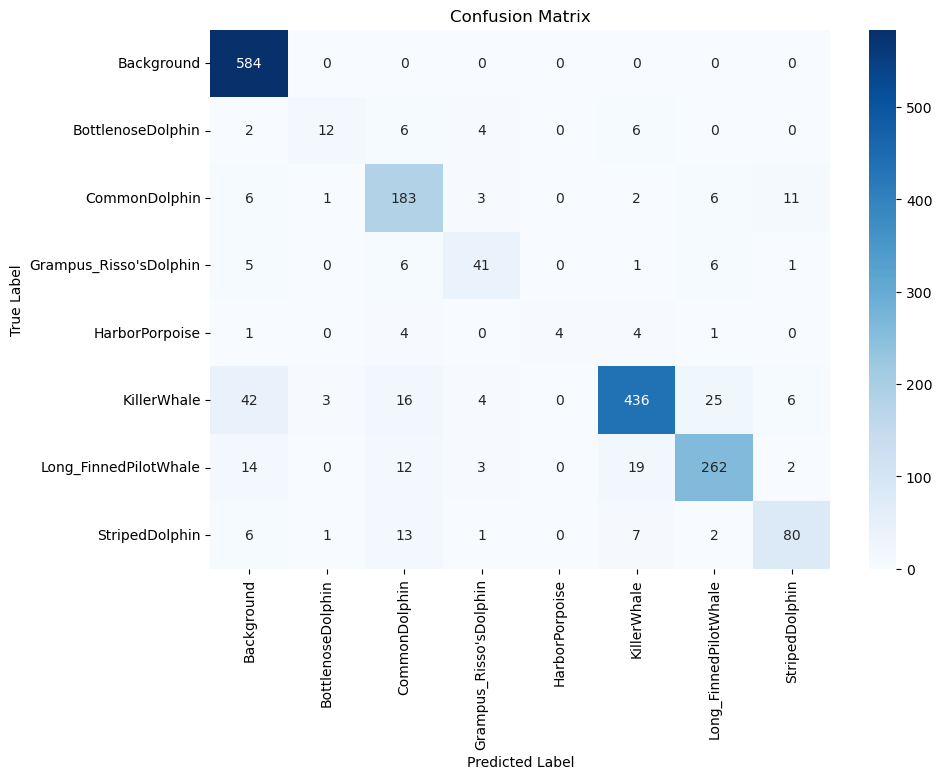

In [62]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, pred_classes, labels=test_labels.columns)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=test_labels.columns, yticklabels=test_labels.columns, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

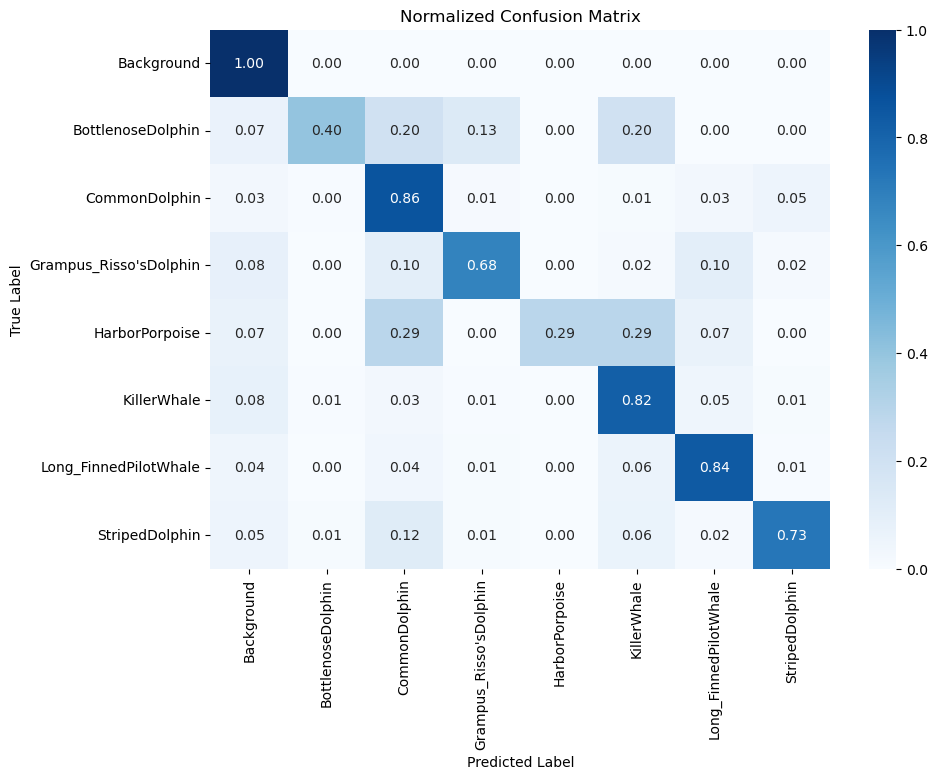

In [69]:
# normalize confusion matrix
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, None]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", xticklabels=test_labels.columns, yticklabels=test_labels.columns, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

In [66]:
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8641


In [67]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(true_classes, pred_classes, average="macro")
weighted_f1 = f1_score(true_classes, pred_classes, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")


Macro F1-score: 0.7365
Weighted F1-score: 0.8601


In [68]:
from sklearn.metrics import roc_auc_score

# Assuming 'preds' contains raw probabilities from the classifier
auc_score = roc_auc_score(test_labels.values, preds, average="macro", multi_class="ovr")
print(f"Macro ROC-AUC Score: {auc_score:.4f}")


Macro ROC-AUC Score: 0.9589
